# Домашняя работа №1
### Выполнила Елизавета Клыкова, БКЛ181

* Написать персептрон с двумя слоями
* Реализовать форвард и бэквард пропогейшен

In [1]:
import time
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import MNIST
from sklearn.metrics import f1_score, accuracy_score, classification_report

## Датасет
Загрузим Мнист. Почему именно он? Мы будем решать задачу бинарной классификации на паре цифр: 3 и 7. Плюсы в том, что примеров для этих чисел достаточно, чтобы обучить НС, у каждого примера не так много фичей (28х28 - размерность картинок) и, в целом, эти классы хорошо отделяются. Я б с радостью показал вам пример с текстами, но если писать НС с нуля и пытаться обучаться на текстах, не факт, что у нас хоть что-то обучится :(

Торч -- объект, который позволяет нормализовать картинки, можно думать о нем как о предобработке (регулярках) для текстов.

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

Загружаем датасет. Возращается особенный торчовый класс, чуть ниже мы зададим его сами и научимся им пользоваться, пока оставляем эз из.


In [3]:
train_dataset = MNIST('.', train=True, download=True, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)

C:\Users\lizak\anaconda3\lib\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Выбираем два класса. Если вы достаточно хорошо знакомы с пандас, то можно понять, что никакой магии здесь нет.

In [4]:
# фильтруем дату по значению таргета, берем 3 или 7
train_dataset.data = train_dataset.data[(train_dataset.targets == 3) | (train_dataset.targets == 7)]
train_dataset.targets = train_dataset.targets[(train_dataset.targets == 3) | (train_dataset.targets == 7)]

# то же самое для тестового набора
test_dataset.data = test_dataset.data[(test_dataset.targets == 3) | (test_dataset.targets == 7)]
test_dataset.targets = test_dataset.targets[(test_dataset.targets == 3) | (test_dataset.targets == 7)]

# препроцессинг лейблов (не у всех значений тип integer, а нам нужен именно он)
# self.long() is equivalent to self.to(torch.int64). See to()
# почему только для 7, непонятно
train_dataset.targets = (train_dataset.targets == 7).long()
test_dataset.targets = (test_dataset.targets == 7).long()

Мы неоднократно говорили, что НС обычно тренируются батчами, в торче есть удобный класс, который позволяет обернуть наши датасеты в итерируемый объект. Если не знаете, что такое итерируемый объект, погуглите :) Можно думать об этом как о списке с составными элементами (элемент -- батч -- набор примеров). 

In [5]:
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

In [6]:
# next(iter(x)) возвращает следующий элемент итератора
X, y = next(iter(train_loader))
X

tensor([[[[-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          ...,
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242]]],


        [[[-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          ...,
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242]]],


        [[[-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.424

In [7]:
y

tensor([0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1,
        1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1,
        0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0,
        1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1,
        0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0,
        1, 0, 0, 0, 0, 0, 1, 1])

Никакой магии, просто многомерные матрицы. Можно даже проверить, что то, что мы получили, т.е. первый батч, имеет правильную размерность. В *y* 1 -- это класс цифры "7", 0 -- "3".

In [8]:
# 128 примеров; [1, 28, 28] - размерность картинки
# 1 значит, что из 3-x каналов (R, G, B) у нас всего 1, а сама картинка 28x28
X.shape

torch.Size([128, 1, 28, 28])

In [9]:
y.shape

torch.Size([128])

Проверим, правда ли это картинки:

In [10]:
X, y = next(iter(train_loader))
X = X.numpy()  # перевод тензора в массив numpy
y = y.numpy()

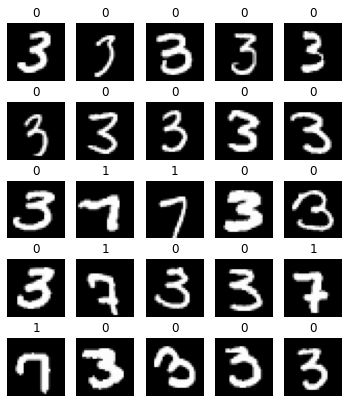

In [11]:
plt.figure(figsize=(6, 7))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(X[i].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title(y[i])
    plt.axis('off')

Нам столько размерностей не нужно, поэтому давайте выпрямим матрицу, тем более, мы знаем, что значение каждого пикселя независимо друг от друга.

In [12]:
X, y = next(iter(train_loader))
X = X.view(X.shape[0], -1)
X.shape

torch.Size([128, 784])

 Размерность
- количество примеров в батче
- количество фичей

In [13]:
y

tensor([1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0,
        1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0,
        0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0,
        1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1,
        1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0,
        0, 1, 0, 0, 0, 0, 0, 0])

Такой *y* нам не совсем подходит. Сейчас объясню почему. Размерность Х (128, 784) матрично перемножим на скрытый слой (784, 1), и получится (128, 1). Нужно понимать, что размерность (128,) и (128, 1) -- это немного разные вещи.

In [14]:
w = torch.rand(784, 1)  # рандомные необученные веса
pred = X.matmul(w)
pred.shape

torch.Size([128, 1])

In [15]:
pred[0:10]

tensor([[-42.1172],
        [-77.2633],
        [-40.1836],
        [ 78.1806],
        [  8.8682],
        [ 17.3985],
        [-42.2030],
        [-22.5076],
        [  6.0035],
        [-35.9149]])

Теперь у нас есть предсказания, их размерность (128,1). Нужно будет считать лосс с *у*, поэтому приведем его к такой же размерности с expand_dims -- эта функция есть в нумпае и в торче.

In [16]:
y = np.expand_dims(y, 1)
y[0:10]

array([[1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1]], dtype=int64)

Итерация по эпохам:

In [17]:
epochs = 3

for n_epoch in range(epochs):
    dataset_passed_samples = 0

    for x, y in train_loader:
        # вот здесь мы могли бы как-то манипулировать с данными
        # например, учить, но пока этого делать не будем

        time.sleep(0.05)
        dataset_passed_samples += x.shape[0]
        dataset_passed_percent = dataset_passed_samples * 100 / train_loader.dataset.data.shape[0]
        print(f'Эпоха {n_epoch + 1}, прошли {dataset_passed_percent:.2f} % датасета', end='\r')

    print('\r')

Эпоха 1, прошли 100.00 % датасета
Эпоха 2, прошли 100.00 % датасета
Эпоха 3, прошли 100.00 % датасета


## Однослойный персептрон

In [18]:
learning_rate = 0.01  # определяет, какую часть от градиента мы будем брать
epochs = 5  # сколько раз мы пройдем по всему тренировочному набору данных

# число примеров в батче: понадобится при обучении, чтобы усреднять лосс
batch_size = 128
n_feat = 784

# нормирование весов (чтобы избежать деления на ноль при бэкпропе)
# 0.01 выбрано эмпирически, т.к. сами фичи имеют значения, близкие к 0
w1 = np.random.rand(n_feat, 1) * 0.01

# размерность должна совпадать с количеством параметров,
# которые у нас останутся после матричного перемножения
b1 = np.zeros(1)  # array([0.])

# на каждой итерации (и для всех эпох) будем сохранять сюда лосс,
# чтобы видеть, обучается ли НС
losses = []

for n_epoch in range(epochs):

    print(f'Epoch: {n_epoch + 1}')

    for x, y in train_loader:

        x = x.view(x.shape[0], -1).numpy()  # приводим к размерности (128,784)
        y = np.expand_dims(y.numpy(), 1)  # приводим к размерности (128,1)

        h1 = x.dot(w1) + b1  # переход в одномерное пространство
        p = 1/(1+np.exp(-h1))  # преобразование в "вероятности"

        # расчет энтропии с усреднением по размеру батча
        bce = (-np.sum(np.multiply(np.log(p), y) + np.multiply((1 - y), np.log(1 - p)))) / batch_size
        losses.append(bce)

        dp = (p - y) / batch_size  # производная bce и sigmoid
        dw1 = np.dot(x.T, dp)  # производная по лин. преобразованию относительно W - весов
        db1 = np.sum(dp)  # производная по лин. преобразованию относительно В - баяса
        # здесь по идее должно быть перемножение на единичный вектор (128,1),
        # но это то же самое, что и сумма значений

        w1 -= learning_rate * dw1  # обновим веса и баясы
        b1 -= learning_rate * db1

Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5


А теперь построим график функции потерь.

Text(0, 0.5, 'Loss function')

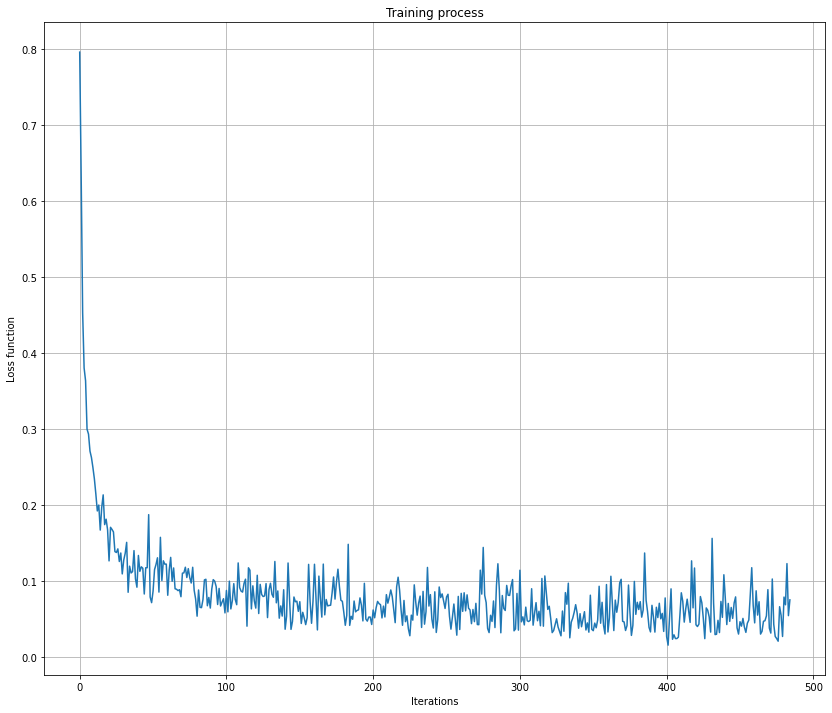

In [19]:
plt.figure(figsize=(14, 12))
plt.plot(losses)
plt.grid()
plt.title('Training process')
plt.xlabel('Iterations')
plt.ylabel('Loss function')

## Математика

![alt text](https://sun9-39.userapi.com/c850608/v850608777/47a4/fgZlI898IUU.jpg)
![alt text](https://sun9-41.userapi.com/c858216/v858216777/cc4f5/v3CPa-tnm80.jpg)
![alt text](https://sun9-67.userapi.com/c857632/v857632471/f6e95/H0dsmWsUInc.jpg)
![alt text](https://sun9-71.userapi.com/c858120/v858120274/10d0ef/hdKO-3Syk3g.jpg)

Двуслойный персептрон:

In [20]:
learning_rate = 0.01
epochs = 5
batch_size = 128
n_feat = 784  # 28x28
inner_feat = 300

w1 = np.random.rand(n_feat, inner_feat) * 0.01  # (784, 300)
b1 = np.zeros(inner_feat)  # (300,)
w2 = np.random.rand(inner_feat, 1) * 0.01  # (300, 1)
b2 = np.zeros(1)  # (1,)

losses = []

for n_epoch in range(epochs):

    print(f'Epoch: {n_epoch + 1}')

    for x, y in train_loader:

        x = x.view(x.shape[0], -1).numpy()  # (128, 784)
        y = np.expand_dims(y.numpy(), 1)  # (128, 1)

        # -----------------------

        # forward

        # z1 - первое линейное преобразование - (BATCH_SIZE, INNER_FEATURES)
        z1 = x.dot(w1) + b1  # (128, 300)
        # a1 - применение нелинейности - (BATCH_SIZE, INNER_FEATURES)
        a1 = 1 / (1 + np.exp(-z1))  # (128, 300)

        # z2 - второе нелинейное преобразование - (BATCH_SIZE, 1)
        z2 = a1.dot(w2) + b2  # (128, 1)
        # pred - сигмоида - (BATCH_SIZE, 1)
        pred = 1 / (1 + np.exp(-z2))  # (128, 1)

        # -----------------------

        # расчет bce

        # loss = -(true_labels*log(predicted) + (1-true_labels)*log(1-predicted))
        bce = (-np.sum(np.multiply(np.log(pred), y) +
                       np.multiply((1 - y), np.log(1 - pred)))) / batch_size
        losses.append(bce)

        # -----------------------

        # backward

        batch_size = x.shape[0]

        # d_BCE/d_pred - градиент функции потерь по pred - (BATCH_SIZE, 1)
        d_pred = (pred - y) / batch_size  # (128, 1)

        # d_pred/dz2 - градиент сигмоиды по z2 - (BATCH_SIZE, 1)
        # d_z2 = exp(-z2) / (1 + exp(-z2))**2

        # dz2/dw2 - градиент линейного преобразования по w2 - (INNER_FEATURES, 1)
        d_w2 = np.dot(a1.T, d_pred)  # (300, 1)

        # dz2/db2 - градиент линейного преобразования по b2 - (1,)
        d_b2 = np.sum(d_pred)  # (1,)

        # da1/dz1 - градиент нелинейной функции по z1 - (BATCH_SIZE, INNER_FEATURES)
        # d_z1 = exp(-z1) / (1 + exp(-z1))**2

        # dz1/dw1 - градиент линейного преобразования по w1 - (IN_FEATURES, INNER_FEATURES)
        d_w1 = np.dot(x.T, np.dot(d_pred, w2.T) * a1 * (1 - a1))  # (784, 300)

        # dz1/db1 - градиент линейного преобразования по b1 - (INNER_FEATURES,)
        d_b1 = np.sum(np.dot(d_pred, w2.T))  # (300,)

        # -----------------------

        # gradient descent

        # обновляем веса и bias'ы
        w2 -= learning_rate * d_w2
        b2 -= learning_rate * d_b2
        w1 -= learning_rate * d_w1
        b1 -= learning_rate * d_b1

Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5


## Подсказки по размерностям

### Forward

- z1 - первое линейное преобразование - (BATCH_SIZE, INNER_FEATURES)
- a1 - применение нелинейности - (BATCH_SIZE, INNER_FEATURES)
- z2 - второе нелинейное преобразование - (BATCH_SIZE, 1)
- pred или a2 - сигмоида - (BATCH_SIZE, 1)
- loss - функция потерь - скаляр

### Backward

- d_BCE/d_pred - градиент функции потерь по pred - (BATCH_SIZE, 1)
- d_pred/dz2 - градиент сигмоиды по z2 - (BATCH_SIZE, 1)
- dz2/da1 - градиент линейного преобразования по a1 - (BATCH_SIZE, INNER_FEATURES)
- dz2/dw2 - градиент линейного преобразования по w2 - (INNER_FEATURES, 1)
- dz2/db2 - градиент линейного преобразования по b2 - (1,)
- da1/dz1 - градиент нелинейной функции по z1 - (BATCH_SIZE, INNER_FEATURES)
- dz1/dw1 - градиент линейного преобразования по w1 - (IN_FEATURES, INNER_FEATURES)
- dz1/db1 - градиент линейного преобразования по b1 - (INNER_FEATURES,)

И график:

Text(0, 0.5, 'Loss function')

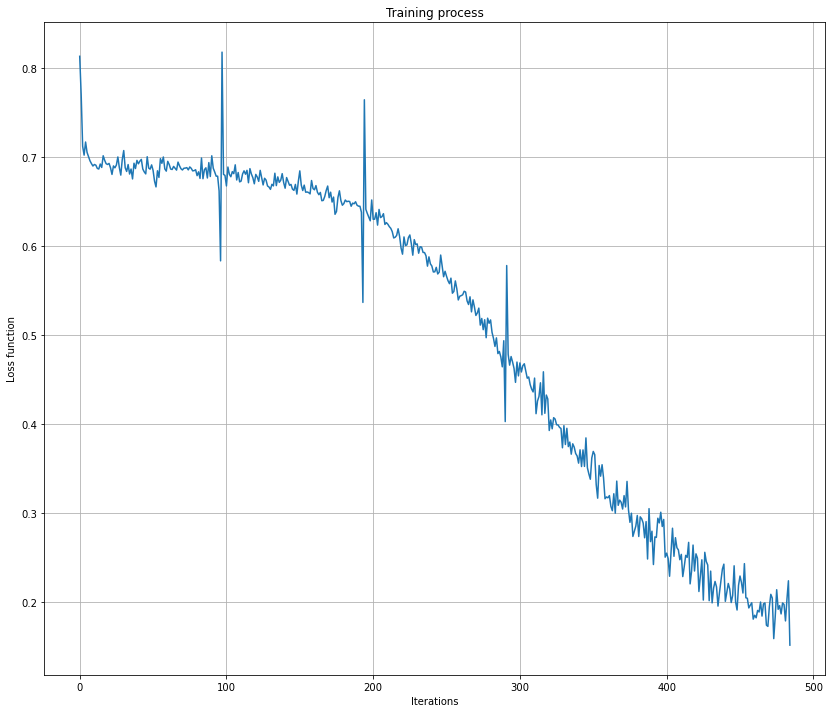

In [21]:
plt.figure(figsize=(14, 12))
plt.plot(losses)
plt.grid()
plt.title('Training process')
plt.xlabel('Iterations')
plt.ylabel('Loss function')

## Тестирование

А как это тестировать? Да очень просто: нужно просто выполнять форвард без бэкворда, то есть последовательно применять преобразования с обученными весами.

In [22]:
losses_test = []
predicted = []
true_lbls = []

for x, y in test_loader:

    x = x.view(x.shape[0], -1).numpy()
    y = np.expand_dims(y.numpy(), 1)

    h1 = x.dot(w1) + b1  # переход в одномерное пространство
    p = 1/(1+np.exp(-h1))  # преобразование в "вероятности"

    # расчет энтропии с усреднением по размеру батча
    bce = (-np.sum(np.multiply(np.log(p), y) +
                   np.multiply((1 - y), np.log(1 - p)))) / batch_size

    losses_test.append(bce)
    predicted.extend(p)
    true_lbls.extend(y)

Проверим, что для каждого семпла у нас есть предсказание:

In [23]:
print(len(predicted), len(true_lbls))

2038 2038


Теперь применим стандартную F-меру и оценим нашу модель.

In [24]:
pred = np.array([round(i[0]) for i in predicted])

# у нас были вероятности, а нужны классы
# поэтому просто округлим каждое значение и получим лейблы
t_lbls = np.array(true_lbls).squeeze()  # снимем лишнюю размерность

f1 = f1_score(pred, t_lbls, average='weighted')
print('F1 score is equal to: {0:0.02f}'.format(f1))

F1 score is equal to: 0.87


Сделайте то же самое для своей модели.

In [25]:
losses_test = []
predicted = []
true_lbls = []

for x, y in test_loader:
    x = x.view(x.shape[0], -1).numpy()  # (128, 784)
    y = np.expand_dims(y.numpy(), 1)  # (128, 1)

    # -----------------------

    # forward

    # z1 - первое линейное преобразование - (BATCH_SIZE, INNER_FEATURES)
    z1 = x.dot(w1) + b1  # (128, 300)
    # a1 - применение нелинейности - (BATCH_SIZE, INNER_FEATURES)
    a1 = 1 / (1 + np.exp(-z1))  # (128, 300)

    # z2 - второе нелинейное преобразование - (BATCH_SIZE, 1)
    z2 = a1.dot(w2) + b2  # (128, 1)
    # pred - сигмоида - (BATCH_SIZE, 1)
    pred = 1 / (1 + np.exp(-z2))  # (128, 1)

    # -----------------------

    # расчет bce

    # loss = -(true_labels*log(predicted) + (1-true_labels)*log(1-predicted))
    bce = (-np.sum(np.multiply(np.log(pred), y) +
                   np.multiply((1 - y), np.log(1 - pred)))) / batch_size

    losses_test.append(bce)
    predicted.extend(pred)
    true_lbls.extend(y)

In [26]:
len(predicted) == len(true_lbls)

True

In [27]:
pred = np.array([round(i[0]) for i in predicted])

t_lbls = np.array(true_lbls).squeeze()

f1 = f1_score(pred, t_lbls, average='weighted')
print('F1 score is equal to: {0:0.02f}'.format(f1))

F1 score is equal to: 0.97


## Немного торча
#### Мы можем определить нашу модель как последовательность уже существующих слоев, как в керасе.

In [28]:
model = torch.nn.Sequential()

model.add_module(name='linear_1', module=torch.nn.Linear(in_features=784, out_features=256))
model.add_module(name='relu', module=torch.nn.ReLU())
model.add_module(name='linear_2', module=torch.nn.Linear(in_features=256, out_features=1))
model.add_module(name='sigmoid', module=torch.nn.Sigmoid())

model

Sequential(
  (linear_1): Linear(in_features=784, out_features=256, bias=True)
  (relu): ReLU()
  (linear_2): Linear(in_features=256, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

#### Либо так:

In [29]:
model = torch.nn.Sequential(
    torch.nn.Linear(in_features=784, out_features=256),
    torch.nn.ReLU(),
    torch.nn.Linear(in_features=256, out_features=1),
    torch.nn.Sigmoid()
)

model

Sequential(
  (0): Linear(in_features=784, out_features=256, bias=True)
  (1): ReLU()
  (2): Linear(in_features=256, out_features=1, bias=True)
  (3): Sigmoid()
)

## А вот для чего нужно было писать в домашке классы
## Для определения своих моделей/слоев/чего вам захочется нам нужно сделать такую структуру

In [30]:
# наследуемся от класса torch.nn.Module
class MLP(torch.nn.Module):

    # определяем метод __init__
    # он нужен для того, чтобы мы могли определить нужные нам слои, веса, сохраняемые операции
    # передаем ссылку на самого себя первым параметром
    # определяем любые другие передаваемые аргументы
    # могут быть чем угодно: числа, словари, другие слои, другие модели и вообще все что угодно

    def __init__(self, in_features, inner_features, out_features):

        # Главная задача этого метода - возможность использования в классе потомке, методов класса-родителя
        # Вызываем __init__ родителя - torch.nn.Module
        super().__init__()

        # определяем слои и все что захотим сохранять/использовать
        self.linear_1 = torch.nn.Linear(in_features=in_features, out_features=inner_features)
        self.non_linear_function = torch.nn.ReLU()
        self.linear_2 = torch.nn.Linear(in_features=inner_features, out_features=out_features)
        self.sigmoid = torch.nn.Sigmoid()

    # нам нужно обязательно реализовать метод forward
    # это то, что нашей модели нужно делать, как оперировать с входными данными, как рассчитывать
    # метод backward нам не нужно реализовывать, потому что в торче есть автоматическое дифференцирование
    # главное, чтобы наши операции были дифференцируемы
    # некоторые подробности можете узнать здесь:
    # https://pytorch.org/tutorials/beginner/blitz/autograd_tutorial.html#sphx-glr-beginner-blitz-autograd-tutorial-py
    # также список доступных дифференцируемых операций можете посмотреть здесь:
    # https://pytorch.org/docs/stable/tensors.html

    def forward(self, x):

        # наша привычная схема
        x = self.linear_1(x)
        x = self.non_linear_function(x)
        x = self.linear_2(x)
        x = self.sigmoid(x)

        return x

    # мы также можем реализовать любые другие полезные нам методы внутри класса

In [31]:
# определяем нашу модель
model = MLP(in_features=784, inner_features=256, out_features=1)
model

MLP(
  (linear_1): Linear(in_features=784, out_features=256, bias=True)
  (non_linear_function): ReLU()
  (linear_2): Linear(in_features=256, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [32]:
# можем посмотреть веса
model.linear_1.weight.shape

torch.Size([256, 784])

In [33]:
# еще нам нужно задать функцию потерь
criterion = torch.nn.BCELoss()

In [34]:
# и оптимизатор, куда нужно передать параметры модели
# параметры модели можно взять методом класса .parameters()
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.01)

In [35]:
# можем посмотреть на параметры нашей модели
params = list(model.parameters())
params

[Parameter containing:
 tensor([[ 0.0291,  0.0284,  0.0088,  ..., -0.0138,  0.0317,  0.0288],
         [-0.0350,  0.0349,  0.0099,  ..., -0.0236, -0.0089,  0.0344],
         [ 0.0092, -0.0256,  0.0106,  ..., -0.0216, -0.0350,  0.0253],
         ...,
         [ 0.0204, -0.0204,  0.0065,  ...,  0.0307, -0.0048,  0.0126],
         [-0.0090, -0.0155, -0.0346,  ..., -0.0260, -0.0007, -0.0050],
         [-0.0099,  0.0234,  0.0049,  ...,  0.0066,  0.0284, -0.0155]],
        requires_grad=True),
 Parameter containing:
 tensor([ 2.8833e-02,  2.9575e-02,  1.1621e-02, -2.7623e-02,  1.8095e-02,
         -3.0264e-02, -3.4287e-02, -3.0562e-02,  8.1303e-04,  9.5380e-04,
          5.0009e-03,  3.0445e-02, -2.7361e-02, -5.7175e-03, -3.2624e-03,
          2.6410e-02,  3.3832e-03, -1.8981e-02, -9.2115e-03, -2.5989e-02,
         -3.0938e-02, -1.4841e-02, -3.3628e-02,  1.1714e-02,  3.3182e-02,
         -1.0284e-02, -1.7307e-02,  2.8895e-02,  3.1603e-02, -3.2353e-02,
          1.0347e-02,  2.9754e-02, -3.37

# Обучим нашу модель

In [36]:
# давайте сохранять значения нашей функции потерь каждую итерацию обучения
losses = []

# эта штука все еще отдает нам батчи данных
# мы поговорим про нее позже
for x, y in train_loader:

    x = x.view(x.shape[0], -1)
    y = y.unsqueeze(1).float()

    # обновим наши градиенты
    # будем делать это каждую итерацию обучения
    # потому что торч сохраняет в себе все градиенты пока не удалите таким образом рассчитанные градиенты

    # НЕОБЯЗАТЕЛЬНЫЕ ДЕТАЛИ
    # функция сохранения градиентов нужна для аккамуляции градиентов
    # например, когда нам не хватает памяти на большой батч
    # мы можем несколько раз прогнать forward на разных батчах
    # наши градиенты будут сохраняться
    # и только потом обновить через несколько итераций forward обновить наши веса
    # таким образом у нас получается больше батч

    optimizer.zero_grad()

    # предсказание нашей модели
    # здесь торч сам сохраняет необходимую информацию
    # чтобы понять эту логику у нас как раз и была часть домашки про собственные классы
    # торч строит динамический граф вычислений
    # то есть строит граф по тем операциям, которые вы определили в методе forward
    # то есть торч понимает, что вы сначала применили линейное преобразование
    # знает, где лежат веса для этого линейного преобразования
    # знает, что вы затем применили релу
    # затем опять линейное преобразование
    # затем сигмоиду
    # и вот таким образом торч выстроил граф
    # который нужен будет для backpropogation

    pred = model(x)

    # рассчитываем функцию потерь, добавляя в наш граф вычислений этот узел
    loss = criterion(pred, y.float())

    # вызываем метод backward() от нашей функции потерь (это крайний узел нашего графа вычислений)
    # этот метод проходит от конца графа в начало, вычисляя необходимые градиенты
    # передаем градиенты на следующие узлы
    # для весов сохраняет
    # то есть это почти то же самое, что мы делали в домашке с классами

    loss.backward()

    # теперь мы знаем необходимые градиенты и можем обновить веса с помощью градиентного спуска
    optimizer.step()

    # сохраним текущее значение функции потерь, чтобы потом могли посмотреть на график
    # очень важный момент: нам нужно отсоединить значение нашей фунции потерь от графа вычислений
    # чтобы граф не строился дальше на каждой итерации обучения
    # так мы рано или поздно переполним память
    # поэтому вызываем этот метод
    # работает для скаляров
    # для тензоров работает метод .tolist()
    current_loss_value = loss.item()
    losses.append(loss.item())

Одна эпоха прошла.

Text(0, 0.5, 'Loss function')

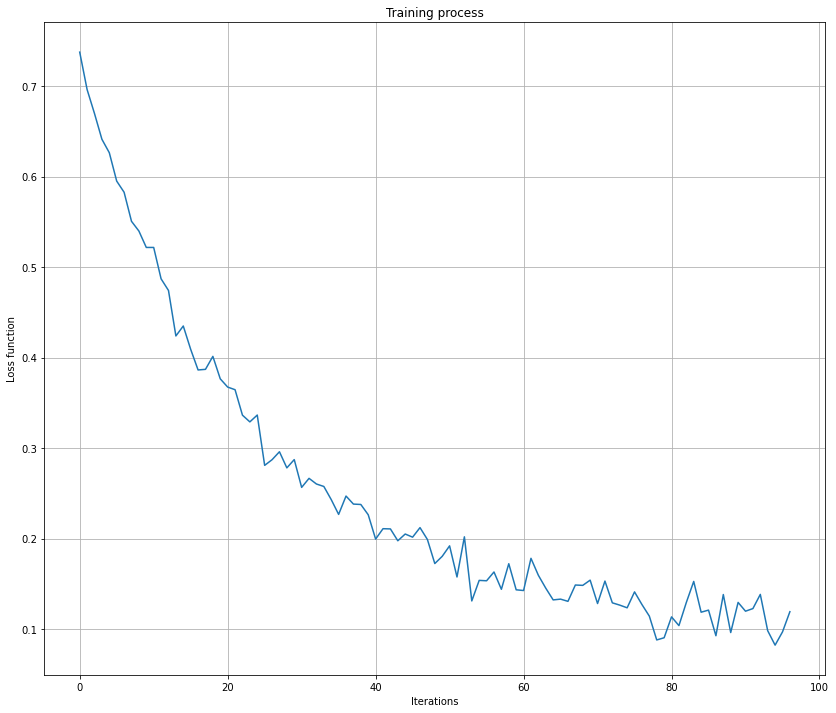

In [37]:
plt.figure(figsize=(14, 12))
plt.plot(losses)
plt.grid()
plt.title('Training process')
plt.xlabel('Iterations')
plt.ylabel('Loss function')

# Теперь мы можем что-то предсказать

In [38]:
for x, y in test_loader:

    x = x.view(x.shape[0], -1)
    y = y.unsqueeze(1).float()

    # чтобы не ходить по всему тестовому датасету, прекратим ходить после первой итерации
    break

In [39]:
x.shape

torch.Size([128, 784])

In [40]:
y.shape

torch.Size([128, 1])

In [41]:
# переходим в режим предсказания
# позже в курсе мы разберем зачем конкретно это нужно

# для искушенного нетерпеливого читателя: дропаут больше не дропаутит,
# батч норм больше не нормирует каждый батч,
# а использует накопленную статистику при обучении и т.д.

model.eval()

MLP(
  (linear_1): Linear(in_features=784, out_features=256, bias=True)
  (non_linear_function): ReLU()
  (linear_2): Linear(in_features=256, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [42]:
# этот контект позволяет не сохранять необходимую информацию для рассчета градиентов
with torch.no_grad():
    pred = model(x)

In [43]:
pred.shape

torch.Size([128, 1])

In [44]:
# избавимся от единичной размерности
pred = pred.squeeze()
y = y.squeeze()

In [45]:
pred.shape

torch.Size([128])

In [46]:
# таким образом из торчовых тензоров мы можем сделать нумпаевские массивы
pred = pred.numpy()
y = y.numpy()

In [47]:
y

array([1., 1., 0., 1., 0., 0., 1., 1., 1., 0., 0., 1., 0., 1., 0., 1., 1.,
       0., 1., 1., 1., 1., 0., 0., 0., 1., 1., 0., 1., 1., 1., 1., 1., 0.,
       1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 1., 1.,
       0., 1., 1., 1., 1., 0., 1., 1., 1., 0., 0., 0., 0., 1., 0., 0., 1.,
       0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 1., 1., 1., 1., 0., 1., 0.,
       0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0.,
       0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.,
       1., 0., 1., 1., 0., 1., 0., 0., 1.], dtype=float32)

In [48]:
type(y)

numpy.ndarray

In [49]:
# бинаризируем наши предсказания
pred[pred > 0.5] = 1
pred[pred <= 0.5] = 0

In [50]:
# посчитаем метрику на батче
accuracy_score(y, pred)

0.953125

In [51]:
# заново определим нашу модель и выучимся несколько эпох
# будут уже новые параметры
model = MLP(in_features=784, inner_features=256, out_features=1)

criterion = torch.nn.BCELoss()
# мы позже поговорим про этот оптимизационный алгоритм
optimizer = torch.optim.Adam(params=model.parameters())

# Типичный цикл обучения с кучей сохранений лоссов

In [52]:
epochs = 10
losses = []
# нужно для early stopping, то есть трекать лучший лосс на валидации
best_test_loss = 10.

for n_epoch in range(epochs):

    train_losses = []
    test_losses = []
    test_preds = []
    test_targets = []

    progress_bar = tqdm(total=len(train_loader.dataset), desc='Epoch {}'.format(n_epoch + 1))

    for x, y in train_loader:

        x = x.view(x.shape[0], -1)
        y = y.unsqueeze(1).float()

        optimizer.zero_grad()

        pred = model(x)

        loss = criterion(pred, y.float())

        loss.backward()

        optimizer.step()

        train_losses.append(loss.item())
        losses.append(loss.item())

        progress_bar.set_postfix(train_loss=np.mean(losses[-100:]))

        progress_bar.update(x.shape[0])

    progress_bar.close()

    for x, y in test_loader:

        x = x.view(x.shape[0], -1)
        y = y.unsqueeze(1).float()

        with torch.no_grad():

            pred = model(x)

        test_preds.append(pred.numpy())
        test_targets.append(y.numpy())

        loss = criterion(pred, y)

        test_losses.append(loss.item())

    mean_test_loss = np.mean(test_losses)

    print('Losses: train - {:.3f}, test = {:.3f}'.format(np.mean(train_losses), mean_test_loss))

    test_preds = np.concatenate(test_preds)
    test_preds = test_preds.squeeze()
    test_targets = np.concatenate(test_targets).squeeze()

    test_preds[test_preds > 0.5] = 1
    test_preds[test_preds <= 0.5] = 0

    accurary = accuracy_score(test_targets, test_preds)

    print('Test: accuracy - {:.3f}'.format(accurary))

    # как раз early stopping
    # то есть: если наша функция потерь на валидационном датасете стала расти, то прекращаем обучение
    # рост фунции потерь на валидационном датасете говорит о переобучении
    # пожалуй, самый популярный метод валидации для нейронных сетей
    if mean_test_loss < best_test_loss:
        best_test_loss = mean_test_loss
    else:
        print('Early stopping')
        break

Epoch 2:   6%|██▉                                             | 768/12396 [00:00<00:02, 4313.98it/s, train_loss=0.0561]

Losses: train - 0.072, test = 0.057
Test: accuracy - 0.980


Epoch 3:   6%|██▉                                             | 768/12396 [00:00<00:02, 5092.91it/s, train_loss=0.0283]

Losses: train - 0.030, test = 0.037
Test: accuracy - 0.988


Epoch 4:   7%|███▍                                            | 896/12396 [00:00<00:02, 4984.21it/s, train_loss=0.0178]

Losses: train - 0.019, test = 0.025
Test: accuracy - 0.991


Epoch 5:   6%|██▉                                             | 768/12396 [00:00<00:02, 4503.19it/s, train_loss=0.0112]

Losses: train - 0.012, test = 0.022
Test: accuracy - 0.992


Epoch 5: 100%|█████████████████████████████████████████████| 12396/12396 [00:02<00:00, 4618.79it/s, train_loss=0.00809]


Losses: train - 0.008, test = 0.022
Test: accuracy - 0.993
Early stopping


Text(0, 0.5, 'Loss function')

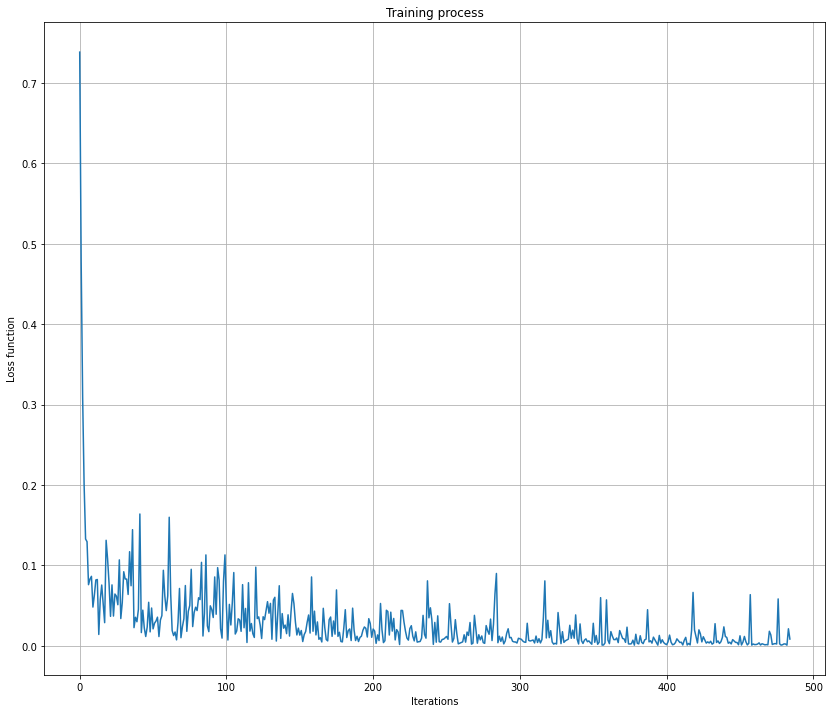

In [53]:
plt.figure(figsize=(14, 12))
plt.plot(losses)
plt.grid()
plt.title('Training process')
plt.xlabel('Iterations')
plt.ylabel('Loss function')